In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Lambda
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

from skimage.transform import resize

In [2]:
# Load the MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

mnist_digits = np.concatenate([x_train, x_test], axis = 0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

# Normalize and reshape the input data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
latent_dim = 2

In [3]:
#Vanilla
input_img_vae = Input(shape=(28, 28, 1))
x = Flatten()(input_img_vae)
encoded_vae = Dense(latent_dim)(x)
decoded_vae = Dense(784)(encoded_vae)
decoded_reshape_vae = Reshape((28, 28, 1))(decoded_vae)

vnlae = Model(input_img_vae, decoded_reshape_vae)
vnlae.compile(optimizer='adam', loss='binary_crossentropy')

with open('modelsummary_vanilla2.txt', 'w') as f:
    vnlae.summary(print_fn=lambda x: f.write(x + '\n'))

In [4]:
#Convolutional
input_img_cae = Input(shape=(28, 28, 1))
latent_dim = 32

x = Conv2D(32, 3, activation='relu', padding='same')(input_img_cae)
x = Conv2D(64, 3, activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
shape_before_flattening_cae = tf.keras.backend.int_shape(x)
x = Flatten()(x)
encoded_cae = Dense(latent_dim)(x)
x = Dense(np.prod(shape_before_flattening_cae[1:]), activation='relu')(encoded_cae)
x = Reshape(shape_before_flattening_cae[1:])(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=(2, 2), padding='same')(x)
decoded_cae = Conv2D(1, 3, activation='sigmoid', padding='same')(x)

cae = Model(input_img_cae, decoded_cae)
cae.compile(optimizer='adam', loss='binary_crossentropy')

with open('modelsummary_conv2.txt', 'w') as f:
    cae.summary(print_fn=lambda x: f.write(x + '\n'))

In [5]:
#VAE
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2
 
encoder_inputs = Input(shape =(28, 28, 1))
encoder = Conv2D(32, 3, activation ="relu", strides = 2, padding ="same")(encoder_inputs)
encoder = Conv2D(64, 3, activation ="relu", strides = 2, padding ="same")(encoder)
encoder = Flatten()(encoder)
x = Dense(16, activation ="relu")(encoder)
z_mean = Dense(latent_dim, name ="z_mean")(encoder)
z_log_var = Dense(latent_dim, name ="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")

latent_inputs = Input(shape =(latent_dim, ))
decoder = Dense(7 * 7 * 64, activation ="relu")(latent_inputs)
decoder = Reshape((7, 7, 64))(decoder)
decoder = Conv2DTranspose(64, 3, activation ="relu", strides = 2, padding ="same")(decoder)
decoder = Conv2DTranspose(32, 3, activation ="relu", strides = 2, padding ="same")(decoder)
decoder_outputs = Conv2DTranspose(1, 3, activation ="sigmoid", padding ="same")(decoder)
decoder = Model(latent_inputs, decoder_outputs, name ="decoder")

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
vae = VAE(encoder, decoder)
vae.compile(optimizer ='adam')



In [6]:
#Sparse 
input_img = Input(shape=(28, 28, 1))
x = Flatten()(input_img)
encoded = Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-5))(x)
decoded = Dense(784, activation='sigmoid')(encoded)
decoded = Reshape((28, 28, 1))(decoded)

sae = Model(input_img, decoded)
sae.compile(optimizer='adam', loss='binary_crossentropy')


with open('modelsummary_sparse2.txt', 'w') as f:
    sae.summary(print_fn=lambda x: f.write(x + '\n'))

In [7]:
#Denoising 
input_img = Input(shape=(28, 28, 1))
noisy_img = input_img + 0.5 * K.random_normal(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(noisy_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

dae = Model(input_img, decoded)
dae.compile(optimizer='adam', loss='binary_crossentropy')
with open('modelsummary_deno2.txt', 'w') as f:
    dae.summary(print_fn=lambda x: f.write(x + '\n'))

In [8]:
# #Define Contractive Autoencoder
# input_shape = (28, 28)
# latent_dim = 32
# lmbda = 0.0001

# # Encoder
# inputs = Input(shape=input_shape)
# flatten = Flatten()(inputs)
# encoded = Dense(latent_dim, activation='relu')(flatten)

# # Decoder
# decoded = Dense(np.prod(input_shape), activation='sigmoid')(encoded)
# reshape = Reshape(input_shape)(decoded)

# # Autoencoder
# ctae = Model(inputs, reshape)

# # Create a penalty term for the contractive loss
# def contractive_loss(y_true, y_pred):
#     mse_loss = mse(y_true, y_pred)
#     hidden = encoded
#     grads = K.gradients(mse_loss, hidden)[0]
#     penalty = K.sum(K.square(grads), axis=1)
#     return mse_loss + lmbda * penalty

# # Compile and train Contractive Autoencoder
# ctae.compile(optimizer='adam', loss=contractive_loss)

# with open('modelsummary_contra2.txt', 'w') as f:
#     ctae.summary(print_fn=lambda x: f.write(x + '\n'))

In [9]:
# Train 
epochs = 1
batch_size = 64

In [10]:
t1 = time.time()
vnlae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test, x_test))
print("Training time:", time.time()-t1, "s")

938/938 [==============================] - 3s 2ms/step - loss: 1.3349 - val_loss: 1.2057
Training time: 2.768667221069336 s


In [11]:
t2 = time.time()
vae.fit(mnist_digits, epochs=epochs, batch_size=batch_size)
print("Training time:", time.time()-t2, "s")


1094/1094 [==============================] - 39s 34ms/step - loss: 289.3323 - reconstruction_loss: 286.0286 - kl_loss: 3.3037
Training time: 38.966840505599976 s


In [12]:
t3 = time.time()
cae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test, x_test))
print("Training time:", time.time()-t3, "s")

938/938 [==============================] - 109s 115ms/step - loss: 0.3010 - val_loss: 0.2744
Training time: 109.01850128173828 s


In [13]:
t4 = time.time()
sae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test, x_test))
print("Training time:", time.time()-t4, "s")

938/938 [==============================] - 4s 3ms/step - loss: 0.3284 - val_loss: 0.2951
Training time: 3.914250612258911 s


In [14]:
t5 = time.time()
dae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(x_test, x_test))
print("Training time:", time.time()-t5, "s")

938/938 [==============================] - 90s 95ms/step - loss: 0.3019 - val_loss: 0.2769
Training time: 89.87606048583984 s


In [15]:
y_true = np.random.randint(0, 2, size=(2, 3))
y_pred = np.random.random(size=(2, 3))
loss = mse(y_true, y_pred)
print(loss)

0.3504679371539039


In [16]:
mscores = []
sscores = []
for autoencoder in [vnlae,cae,sae,dae]:
    predicted_outputs = autoencoder.predict(x_test)

    msea = mse(x_test, predicted_outputs)
    print("MSE:", msea)
    
    ssima = np.mean([ssim(img1, img2, data_range=1, channel_axis = 2) for img1, img2 in zip(x_test, predicted_outputs)])
    print("SSIM:", ssima)
    

313/313 [==============================] - 0s 735us/step
MSE: 0.18672014039708415
SSIM: 0.084039696
313/313 [==============================] - 5s 14ms/step
MSE: 0.010363760446596575
SSIM: 0.76713854
313/313 [==============================] - 0s 1ms/step
MSE: 0.013642646413241045
SSIM: 0.69706494
313/313 [==============================] - 3s 10ms/step
MSE: 0.009538793940763774
SSIM: 0.75410175


In [17]:
import seaborn as sns
sns.set_theme()

313/313 [==============================] - 0s 1ms/step


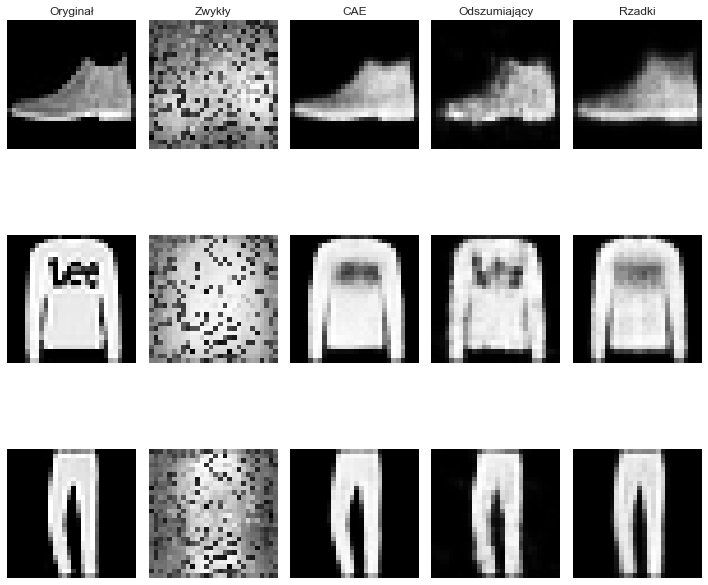

In [18]:

reconstructed_images = []
autoencoders = [vnlae,cae,dae,sae]
reconstructed_images.append(x_test[:5])

for autoencoder in autoencoders:
    reconstructed = autoencoder.predict(x_test)
    reconstructed_images.append(reconstructed[:5])  # Take the first 5 

# Plot the reconstructed images
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 10))

for i in range(3):
    for j in range(5):
        axes[i, j].imshow(reconstructed_images[j][i].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')

axes[0, 0].set_title("Oryginał")
axes[0, 1].set_title("Zwykły")
axes[0, 2].set_title("CAE")
axes[0, 3].set_title("Odszumiający")
axes[0, 4].set_title("Rzadki")

plt.tight_layout()
plt.savefig('comparison_fmnist.png', dpi = 300)
plt.show()